In [1]:
import gpytorch
import linear_operator
from linear_operator.operators import DiagLinearOperator
from lodegp.LODEGP import LODEGP
import torch
from torch import pi
from matplotlib import pyplot as plt
from time import perf_counter

torch.set_default_dtype(torch.float64)
"""
System: Angular velocity of a permanent magnet synchronous motor
with the motor torque 3/4  * p * Phi * i_q(t) = tau(t)

J_m * omega'(t) + b_m * omega(t) - 3/4 * p * Phi * i_q(t) = 0
"""
sp = {"bm": float(0.05), "Jm": float(0.01), "p": float(8), "Phi": float(0.02)}
COUNT = int(400)
TRAIN_ITERATIONS = int(50)

In [2]:
START = float(0)
END = float(2)
train_x = torch.linspace(START, END, COUNT)

TEST_START = float(0)
TEST_END = float(2)
TEST_COUNT = int(200)
test_x = torch.linspace(TEST_START, TEST_END, TEST_COUNT)


steps_s = COUNT / END
# generate input with missing i_q obs
cosine_interp = lambda x, y0, y1, a, b: y0 + (y1 - y0) * (float(1) - torch.cos(pi * (x-a)/(b-a))) / float(2)
omega = torch.zeros_like(train_x)
ramp = cosine_interp(train_x, float(0), float(100), float(0.1), float(0.9))
omega[int(0.1 * steps_s): int(0.9 * steps_s)] = ramp[int(0.1 * steps_s): int(0.9 * steps_s)]
omega[int(0.9 * steps_s): int(1.1 * steps_s)] = torch.full([int(0.2 * steps_s)], float(100))
ramp = cosine_interp(train_x, float(100), float(0), float(1.1), float(1.9))
omega[int(1.1 * steps_s): int(1.9 * steps_s)] = ramp[int(1.1 * steps_s): int(1.9 * steps_s)]
iq = torch.full([COUNT], torch.nan)
bm_c = sp["bm"] / (float(3)/float(4) * sp["p"] * sp["Phi"])
iq[:int(0.1 * steps_s)] = torch.zeros(int(0.1 * steps_s))
iq[int(1.9 * steps_s):] = torch.zeros(int(0.1 * steps_s))
train_y = torch.stack([omega, iq], dim=int(-1))
# create target i_q
d_cos = lambda x, y0, y1, a, b: pi*(y1-y0)*torch.sin(pi*(x-a)/(b-a)) / (2*(b-a))
J_c = sp["Jm"] / (float(3)/float(4) * sp["p"] * sp["Phi"])
iq_target = torch.full([COUNT], torch.nan)
d_omega = d_cos(train_x, float(0), float(100), float(0.1), float(0.9))
ramp_up = J_c * d_omega + bm_c * omega
iq_target[int(0.1 * steps_s): int(0.9 * steps_s)] = ramp_up[int(0.1 * steps_s): int(0.9 * steps_s)]
d_omega = d_cos(train_x, float(100), float(0), float(1.1), float(1.9))
ramp_up = J_c * d_omega + bm_c * omega
iq_target[int(1.1 * steps_s): int(1.9 * steps_s)] = ramp_up[int(1.1 * steps_s): int(1.9 * steps_s)]

iq_target[int(0.9 * steps_s):int(1.1 * steps_s)] = torch.full([int(0.2 * steps_s)], bm_c * float(100))


## generate input with missing i_q obs
#cosine_interp = lambda x, y0, y1, a, b: y0 + (y1 - y0) * (float(1) - torch.cos(pi * (x-a)/(b-a))) / float(2)
#omega = cosine_interp(train_x, float(0), float(100), float(0), float(0.9))
#omega[int(1.8 * steps_s):] = torch.zeros(int(0.2 * steps_s))
#iq = torch.full([COUNT], torch.nan)
#iq[int(1.8 * steps_s):] = torch.zeros(int(0.2 * steps_s))
#iq[int(0)] = float(0)
#train_y = torch.stack([omega, iq], dim=int(-1))
## create target i_q
#bm_c = sp["bm"] / (float(3)/float(4) * sp["p"] * sp["Phi"])
#d_cos = lambda x, y0, y1, a, b: pi*(y1-y0)*torch.sin(pi*(x-a)/(b-a)) / (2*(b-a))
#d_omega = d_cos(train_x, float(0), float(100), float(0), float(0.9))
#J_c = sp["Jm"] / (float(3)/float(4) * sp["p"] * sp["Phi"])
#iq_target = J_c * d_omega + bm_c * omega
#iq_target[int(1.8 * steps_s):] = torch.zeros(int(0.2 * steps_s))

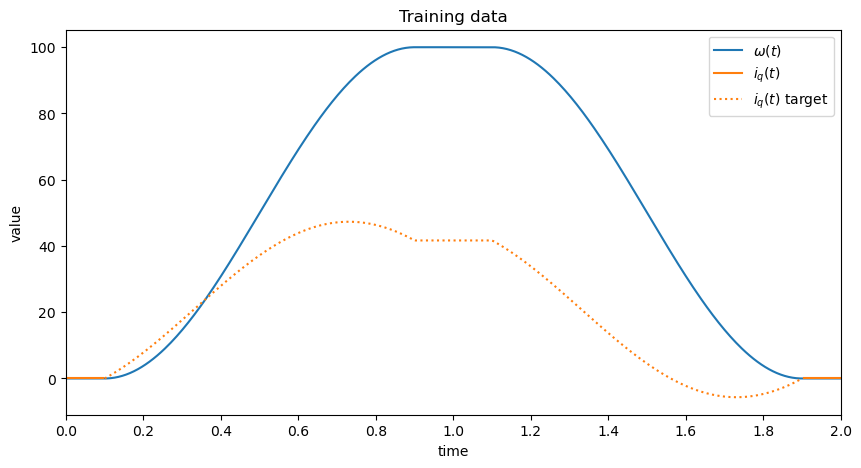

In [3]:
f = plt.figure(figsize=(int(10),int(5)))
plt.title("Training data")
plt.xlabel("time")
plt.ylabel("value")
plt.xlim(START, END)
plt.xticks(torch.arange(START, END+float(0.2), float(0.2)))
lines = plt.plot(train_x, train_y)
target_line = plt.plot(train_x, iq_target)
target_line[0].set_color(lines[1].get_color())
target_line[0].set_linestyle(":")
plt.legend(["$\\omega(t)$", "$i_q(t)$", "$i_q(t)$ target"])
plt.show()

In [4]:
class NoiseStrategy:
    def get_noise(self, *, noise, task_noises, noise_matrix, mask, train_x, test_x):
        raise NotImplementedError

class ManualNoiseStrategy(NoiseStrategy):
    def __init__(self, manual_noise_values, manual_noise_mask):
        self.manual_noise_values = manual_noise_values  # Shape: (N_train, num_tasks)
        self.manual_noise_mask = manual_noise_mask  # Shape: (N_train, num_tasks)

    def get_noise(self, *, noise, task_noises, noise_matrix, mask, train_x, test_x, num_tasks, is_training):
        """
        Compute the noise matrix to be added to the GP covariance.
        """
        if is_training or (not is_training and test_x is None):
            # TRAINING MODE → Apply manual noise to masked entries
            learned_diag = noise_matrix.diagonal()
            full_mask = mask.flatten()
            manual_noise_flat = self.manual_noise_values.flatten()
            combined_noise_diag = torch.where(full_mask, manual_noise_flat, learned_diag)
            return DiagLinearOperator(combined_noise_diag)

        else:
            # PREDICTION MODE → No noise on test points
            # Return zero noise added to covariance
            num_points = test_x.size(int(0))
            return DiagLinearOperator(torch.zeros(num_points * num_tasks, device=test_x.device, dtype=test_x.dtype))



class ManualNoiseLikelihood(gpytorch.likelihoods.MultitaskGaussianLikelihood):
    def set_noise_strategy(self, noise_strategy: NoiseStrategy):
        self.noise_strategy = noise_strategy

    def marginal(self, function_dist, *params, **kwargs):
        mean = function_dist.mean
        covar = function_dist.lazy_covariance_matrix

        if not hasattr(self, "noise_strategy"):
            return super().marginal(function_dist, *params, **kwargs)

        mask = kwargs.get("mask", self.noise_strategy.manual_noise_mask)
        train_x = kwargs["train_data"] if "train_data" in kwargs else params[int(0)]
        test_x = kwargs.get("test_data", None)

        # Base learned noise matrix
        # Infer the shape from the function distribution's mean
        num_data = function_dist.mean.numel() // self.num_tasks
        base_noise_matrix = self._shaped_noise_covar((num_data, self.num_tasks), add_noise=self.has_global_noise)

        num_tasks = self.num_tasks

        new_noise = self.noise_strategy.get_noise(
            noise=self.noise,
            task_noises=self.task_noises,
            noise_matrix=base_noise_matrix,
            mask=mask,
            train_x=train_x,
            test_x=test_x,
            num_tasks=num_tasks,
            is_training=self.training
        )

        result_covar = covar + new_noise
        return function_dist.__class__(mean, result_covar)

In [5]:
print("Training with GPyTorch noise")
# model definition
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=int(2))
model = LODEGP(
    train_x, train_y, likelihood, int(2),
    ODE_name="PMSM",
    system_parameters=sp,
    base_kernel="SE_kernel"
)
model.train()
likelihood.train()
optimizer = torch.optim.Adam(model.parameters(), lr=float(0.01))
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

with gpytorch.settings.observation_nan_policy("mask"):
    start_time = perf_counter()
    for i in range(TRAIN_ITERATIONS):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()
    print(f"Training time: {perf_counter() - start_time:.2f}s")

# model definition
likelihood_matern = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=int(2))
model_matern = LODEGP(
    train_x, train_y, likelihood_matern, int(2),
    ODE_name="PMSM",
    system_parameters=sp,
    base_kernel="Matern_kernel_32"
)
model_matern.train()
likelihood_matern.train()
optimizer = torch.optim.Adam(model_matern.parameters(), lr=float(0.01))
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_matern, model_matern)

with gpytorch.settings.observation_nan_policy("mask"):
    start_time = perf_counter()
    for i in range(TRAIN_ITERATIONS):
        optimizer.zero_grad()
        output = model_matern(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()
    print(f"Training time Matern: {perf_counter() - start_time:.2f}s")

# model definition
likelihood_approx = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=int(2))
model_approx = LODEGP(
    train_x, train_y, likelihood_approx, int(2),
    ODE_name="PMSM",
    system_parameters=sp,
    approx=True,
    number_of_eigenvalues=int(50),
    base_kernel="SE_kernel"
)
model_approx.train()
likelihood_approx.train()
optimizer = torch.optim.Adam(model_approx.parameters(), lr=float(0.01))
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_approx, model_approx)

with gpytorch.settings.observation_nan_policy("mask"), linear_operator.settings.max_cholesky_size(1), gpytorch.settings.max_preconditioner_size(0):
    start_time = perf_counter()
    for i in range(TRAIN_ITERATIONS):
        optimizer.zero_grad()
        output = model_approx(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()
    print(f"Training time Approx: {perf_counter() - start_time:.2f}s")

to_plot = dict()

Training with GPyTorch noise
Training time: 3.74s
Training time Matern: 3.47s
Training time Approx: 4.73s


In [6]:
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.observation_nan_policy("mask"), gpytorch.settings.fast_pred_var():
    start_time = perf_counter()
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    # compute confidence region
    # we want to use lazily evaluated kernel and cannot call forward(..., diag=True)
    var = predictions.covariance_matrix.diagonal().view(mean.size())
    lower = mean - float(2) * var.sqrt()
    upper = mean + float(2) * var.sqrt()
    print(f"Eval time: {perf_counter() - start_time:.2f}s")
    to_plot["mean"] = mean
    to_plot["lower"] = lower
    to_plot["upper"] = upper

model_matern.eval()
likelihood_matern.eval()
with torch.no_grad(), gpytorch.settings.observation_nan_policy("mask"), gpytorch.settings.fast_pred_var():
    start_time = perf_counter()
    predictions = likelihood_matern(model_matern(test_x))
    mean = predictions.mean
    # compute confidence region
    # we want to use lazily evaluated kernel and cannot call forward(..., diag=True)
    var = predictions.covariance_matrix.diagonal().view(mean.size())
    lower = mean - float(2) * var.sqrt()
    upper = mean + float(2) * var.sqrt()
    print(f"Eval time Matern: {perf_counter() - start_time:.2f}s")
    to_plot["mean_matern"] = mean
    to_plot["lower_matern"] = lower
    to_plot["upper_matern"] = upper

model_approx.eval()
likelihood_approx.eval()
with torch.no_grad(), gpytorch.settings.observation_nan_policy("mask"), linear_operator.settings.max_cholesky_size(1), gpytorch.settings.max_preconditioner_size(0), gpytorch.settings.fast_pred_var():
    start_time = perf_counter()
    predictions = likelihood_approx(model_approx(test_x))
    mean = predictions.mean
    # compute confidence region
    # (we want to use lazily evaluated kernel and cannot call forward(..., diag=True)
    var = predictions.covariance_matrix.diagonal().view(mean.size())
    lower = mean - float(2) * var.sqrt()
    upper = mean + float(2) * var.sqrt()
    print(f"Eval time Approximate: {perf_counter() - start_time:.2f}s")
    to_plot["mean_approx"] = mean
    to_plot["lower_approx"] = lower
    to_plot["upper_approx"] = upper

print("\nModel paramters:")
for param in model.named_parameters():
    print(param)
print("\nMatern Model paramters:")
for param in model_matern.named_parameters():
    print(param)
print("\nApprox Model paramters:")
for param in model_approx.named_parameters():
    print(param)

Eval time: 0.26s
Eval time Matern: 0.26s
Eval time Approximate: 0.16s

Model paramters:
('likelihood.raw_task_noises', Parameter containing:
tensor([0.4492, 0.3599], requires_grad=True))
('likelihood.raw_noise', Parameter containing:
tensor([0.4463], requires_grad=True))
('model_parameters.signal_variance_1', Parameter containing:
tensor(0.3401, requires_grad=True))
('model_parameters.lengthscale_1', Parameter containing:
tensor(-0.3114, requires_grad=True))

Matern Model paramters:
('likelihood.raw_task_noises', Parameter containing:
tensor([-0.5046, -0.4894], requires_grad=True))
('likelihood.raw_noise', Parameter containing:
tensor([-0.5035], requires_grad=True))
('model_parameters.signal_variance_1', Parameter containing:
tensor(0.3650, requires_grad=True))
('model_parameters.lengthscale_1', Parameter containing:
tensor(-0.2976, requires_grad=True))

Approx Model paramters:
('likelihood.raw_task_noises', Parameter containing:
tensor([0.4498, 0.3590], requires_grad=True))
('likeliho

In [7]:
print("Training with manual noise")
likelihood = ManualNoiseLikelihood(num_tasks=int(2), noise_constraint=gpytorch.constraints.GreaterThan(float(0)))
manual_noise_values = torch.full_like(train_y, float(1e-9))
manual_noise_mask = torch.full_like(train_y, False, dtype=torch.bool)
manual_noise_mask = torch.where(torch.isnan(train_y), False, True)
#manual_noise_mask = torch.full_like(train_y, False, dtype=torch.bool)
#manual_noise_mask[:, int(0)] = True
manual_noise_strat = ManualNoiseStrategy(manual_noise_values, manual_noise_mask)
likelihood.set_noise_strategy(manual_noise_strat)

model = LODEGP(
    train_x, train_y, likelihood, int(2),
    ODE_name="PMSM",
    system_parameters=sp,
    base_kernel="SE_kernel"
)
model.train()
likelihood.train()
optimizer = torch.optim.Adam(model.parameters(), lr=float(0.01))
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

with gpytorch.settings.observation_nan_policy("mask"):
    start_time = perf_counter()
    for i in range(TRAIN_ITERATIONS):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y, train_data=train_x)
        loss.backward()
        optimizer.step()
    print(f"Training time: {perf_counter() - start_time:.2f}s")

# model definition
likelihood_matern = ManualNoiseLikelihood(num_tasks=int(2), noise_constraint=gpytorch.constraints.GreaterThan(float(0)))
likelihood_matern.set_noise_strategy(manual_noise_strat)
model_matern = LODEGP(
    train_x, train_y, likelihood_matern, int(2),
    ODE_name="PMSM",
    system_parameters=sp,
    base_kernel="Matern_kernel_32"
)
model_matern.train()
likelihood_matern.train()
optimizer = torch.optim.Adam(model_matern.parameters(), lr=float(0.01))
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_matern, model_matern)

with gpytorch.settings.observation_nan_policy("mask"):
    start_time = perf_counter()
    for i in range(TRAIN_ITERATIONS):
        optimizer.zero_grad()
        output = model_matern(train_x)
        loss = -mll(output, train_y, train_data=train_x)
        loss.backward()
        optimizer.step()
    print(f"Training time Matern: {perf_counter() - start_time:.2f}s")

# model definition
likelihood_approx = ManualNoiseLikelihood(num_tasks=int(2), noise_constraint=gpytorch.constraints.GreaterThan(float(0)))
likelihood_approx.set_noise_strategy(manual_noise_strat)

model_approx = LODEGP(
    train_x, train_y, likelihood_approx, int(2),
    ODE_name="PMSM",
    system_parameters=sp,
    approx=True,
    number_of_eigenvalues=int(50),
    base_kernel="SE_kernel"
)
model_approx.train()
likelihood_approx.train()
optimizer_approx = torch.optim.Adam(model_approx.parameters(), lr=float(0.01))
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_approx, model_approx)

with gpytorch.settings.observation_nan_policy("mask"), linear_operator.settings.max_cholesky_size(1), gpytorch.settings.max_preconditioner_size(0):
    start_time = perf_counter()
    for i in range(TRAIN_ITERATIONS):
        optimizer_approx.zero_grad()
        output = model_approx(train_x)
        loss = -mll(output, train_y, train_data=train_x)
        loss.backward()
        optimizer_approx.step()
    print(f"Training time Approx: {perf_counter() - start_time:.2f}s")

Training with manual noise
Training time: 3.79s
Training time Matern: 3.62s
Training time Approx: 29.01s


In [8]:
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.observation_nan_policy("mask"), gpytorch.settings.fast_pred_var():
    start_time = perf_counter()
    predictions = likelihood(model(test_x), train_data=train_x, test_data=test_x)
    mean = predictions.mean
    # compute confidence region
    # we want to use lazily evaluated kernel and cannot call forward(..., diag=True)
    var = predictions.covariance_matrix.diagonal().view(mean.size())
    lower = mean - float(2) * var.sqrt()
    upper = mean + float(2) * var.sqrt()
    print(f"Eval time: {perf_counter() - start_time:.2f}s")
    to_plot["mean_manual"] = mean
    to_plot["lower_manual"] = lower
    to_plot["upper_manual"] = upper

model_matern.eval()
likelihood_matern.eval()
with torch.no_grad(), gpytorch.settings.observation_nan_policy("mask"), gpytorch.settings.fast_pred_var():
    start_time = perf_counter()
    predictions = likelihood_matern(model_matern(test_x), train_data=train_x, test_data=test_x)
    mean = predictions.mean
    # compute confidence region
    # we want to use lazily evaluated kernel and cannot call forward(..., diag=True)
    var = predictions.covariance_matrix.diagonal().view(mean.size())
    lower = mean - float(2) * var.sqrt()
    upper = mean + float(2) * var.sqrt()
    print(f"Eval time Matern: {perf_counter() - start_time:.2f}s")
    to_plot["mean_matern_manual"] = mean
    to_plot["lower_matern_manual"] = lower
    to_plot["upper_matern_manual"] = upper

model_approx.eval()
likelihood_approx.eval()
with torch.no_grad(), gpytorch.settings.observation_nan_policy("mask"), linear_operator.settings.max_cholesky_size(1), gpytorch.settings.max_preconditioner_size(0), gpytorch.settings.fast_pred_var():
    start_time = perf_counter()
    predictions = likelihood(model(test_x), train_data=train_x, test_data=test_x)
    mean = predictions.mean
    # compute confidence region
    # (we want to use lazily evaluated kernel and cannot call forward(..., diag=True)
    var = predictions.covariance_matrix.diagonal().view(mean.size())
    lower = mean - float(2) * var.sqrt()
    upper = mean + float(2) * var.sqrt()
    print(f"Eval time Approximate: {perf_counter() - start_time:.2f}s")
    to_plot["mean_approx_manual"] = mean
    to_plot["lower_approx_manual"] = lower
    to_plot["upper_approx_manual"] = upper

print("\nModel paramters:")
for param in model.named_parameters():
    print(param)
print("\nMatern Model paramters:")
for param in model_matern.named_parameters():
    print(param)
print("\nApprox Model paramters:")
for param in model_approx.named_parameters():
    print(param)

Eval time: 0.27s
Eval time Matern: 0.25s
Eval time Approximate: 0.15s

Model paramters:
('likelihood.raw_task_noises', Parameter containing:
tensor([0., 0.], requires_grad=True))
('likelihood.raw_noise', Parameter containing:
tensor([0.], requires_grad=True))
('model_parameters.signal_variance_1', Parameter containing:
tensor(0.4469, requires_grad=True))
('model_parameters.lengthscale_1', Parameter containing:
tensor(-0.4664, requires_grad=True))

Matern Model paramters:
('likelihood.raw_task_noises', Parameter containing:
tensor([0., 0.], requires_grad=True))
('likelihood.raw_noise', Parameter containing:
tensor([0.], requires_grad=True))
('model_parameters.signal_variance_1', Parameter containing:
tensor(-0.0059, requires_grad=True))
('model_parameters.lengthscale_1', Parameter containing:
tensor(0.2742, requires_grad=True))

Approx Model paramters:
('likelihood.raw_task_noises', Parameter containing:
tensor([0., 0.], requires_grad=True))
('likelihood.raw_noise', Parameter containing

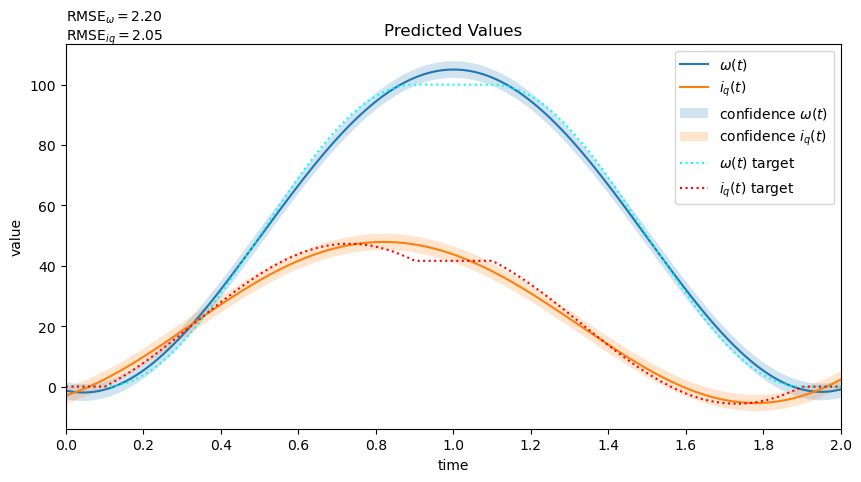

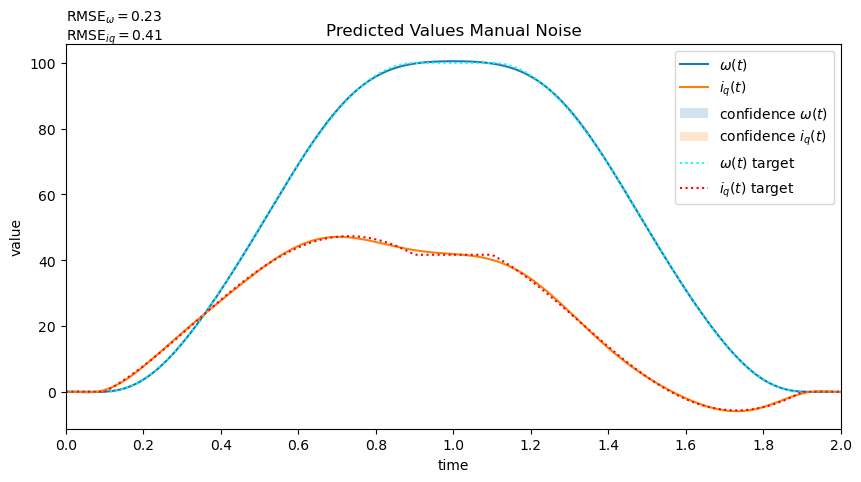

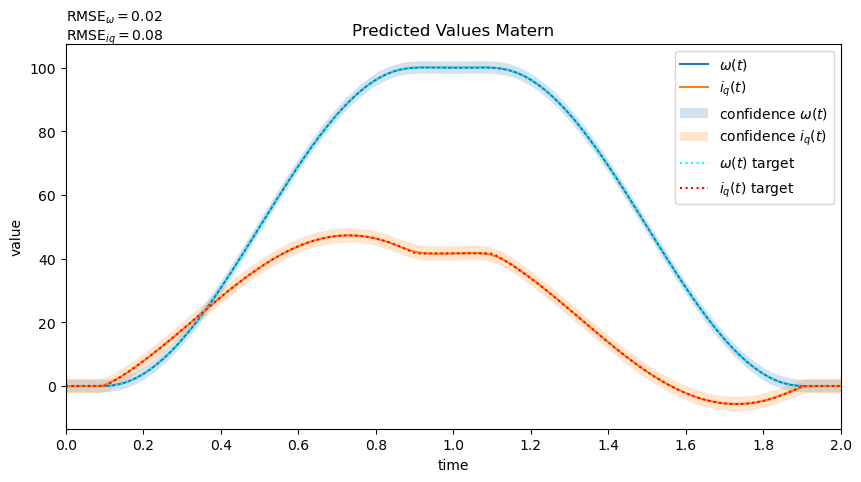

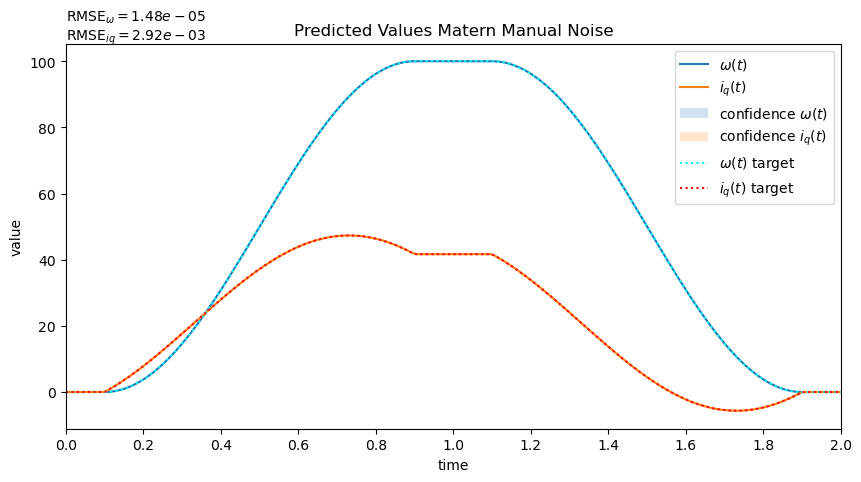

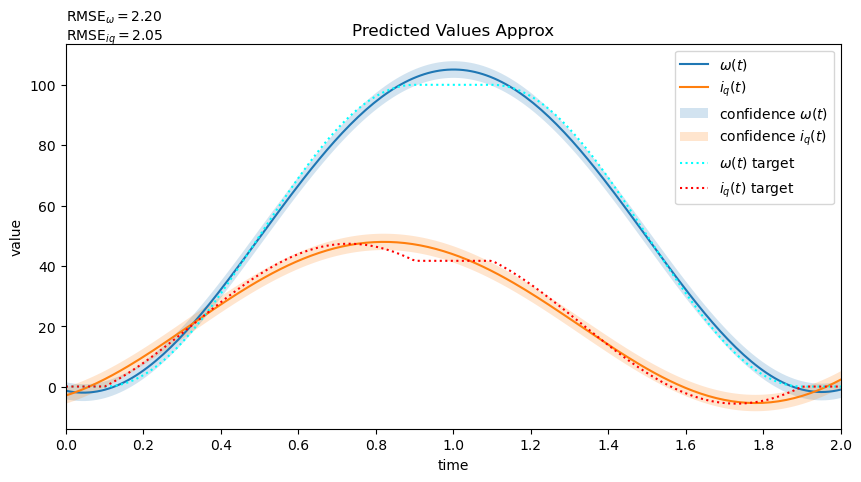

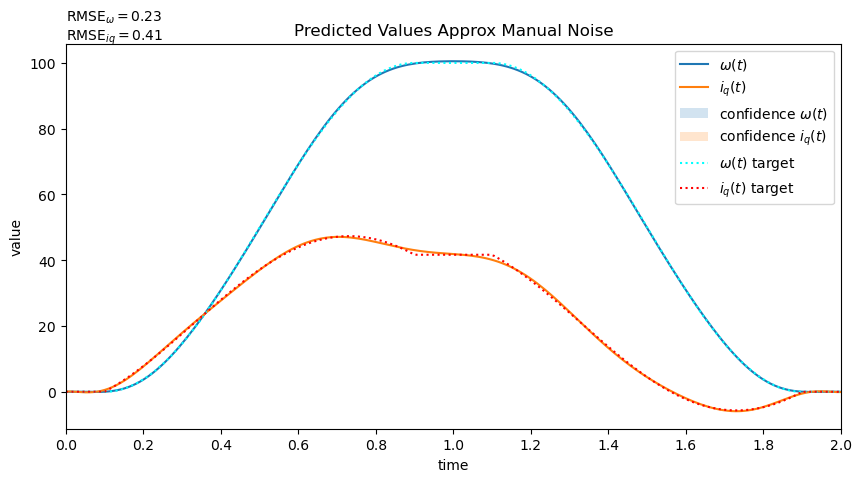

In [9]:
import numpy as np
def plot(m, low, up, title, annotation=None):
    f = plt.figure(figsize=(int(10),int(5)))
    plt.title(title)
    plt.xlabel("time")
    plt.ylabel("value")
    plt.xlim(START, END)
    test_y = torch.stack([m[:, 0], m[:, 1]], dim=int(-1))
    plt.plot(test_x, test_y)
    plt.fill_between(test_x, low[:, 0], up[:, 0], alpha=0.2)
    plt.fill_between(test_x, low[:, 1], up[:, 1], alpha=0.2)
    target_line = plt.plot(test_x, omega)
    target_line[0].set_color("cyan")
    target_line[0].set_linestyle(":")
    target_line = plt.plot(test_x, iq_target)
    target_line[0].set_color("red")
    target_line[0].set_linestyle(":")
    plt.xticks(torch.arange(START, END+float(.2), float(0.2)))
    plt.annotate(text=annotation, xy=(0, 1.01), xycoords='axes fraction')
    plt.legend(["$\\omega(t)$", "$i_q(t)$", "confidence $\\omega(t)$", "confidence $i_q(t)$", "$\\omega(t)$ target", "$i_q(t)$ target"])

# # create targets in test sizes
steps_s = TEST_COUNT / TEST_END

cosine_interp = lambda x, y0, y1, a, b: y0 + (y1 - y0) * (float(1) - torch.cos(pi * (x-a)/(b-a))) / float(2)
omega = torch.zeros_like(test_x)
ramp = cosine_interp(test_x, float(0), float(100), float(0.1), float(0.9))
omega[int(0.1 * steps_s): int(0.9 * steps_s)] = ramp[int(0.1 * steps_s): int(0.9 * steps_s)]
omega[int(0.9 * steps_s): int(1.1 * steps_s)] = torch.full([int(0.2 * steps_s)], float(100))
ramp = cosine_interp(test_x, float(100), float(0), float(1.1), float(1.9))
omega[int(1.1 * steps_s): int(1.9 * steps_s)] = ramp[int(1.1 * steps_s): int(1.9 * steps_s)]
bm_c = sp["bm"] / (float(3)/float(4) * sp["p"] * sp["Phi"])
d_cos = lambda x, y0, y1, a, b: pi*(y1-y0)*torch.sin(pi*(x-a)/(b-a)) / (2*(b-a))
J_c = sp["Jm"] / (float(3)/float(4) * sp["p"] * sp["Phi"])
iq_target = torch.full([COUNT//int(2)], torch.nan)
iq_target[:int(0.1 * steps_s)] = torch.zeros(int(0.1 * steps_s))
d_omega = d_cos(test_x, float(0), float(100), float(0.1), float(0.9))
ramp_up = J_c * d_omega + bm_c * omega
iq_target[int(0.1 * steps_s): int(0.9 * steps_s)] = ramp_up[int(0.1 * steps_s): int(0.9 * steps_s)]
iq_target[int(0.9 * steps_s):int(1.1 * steps_s)] = torch.full([int(0.2 * steps_s)], bm_c * float(100))
d_omega = d_cos(test_x, float(100), float(0), float(1.1), float(1.9))
ramp_up = J_c * d_omega + bm_c * omega
iq_target[int(1.1 * steps_s): int(1.9 * steps_s)] = ramp_up[int(1.1 * steps_s): int(1.9 * steps_s)]
iq_target[int(1.9 * steps_s):] = torch.zeros(int((TEST_END-1.9) * steps_s))

## generate input with missing i_q obs
#cosine_interp = lambda x, y0, y1, a, b: y0 + (y1 - y0) * (float(1) - torch.cos(pi * (x-a)/(b-a))) / float(2)
#omega = cosine_interp(test_x, float(0), float(100), float(0), float(0.9))
#omega[int(1.8 * steps_s):] = torch.zeros(int(0.2 * steps_s))
#iq = torch.full([(COUNT//int(2))], torch.nan)
#iq[int(1.8 * steps_s):] = torch.zeros(int(0.2 * steps_s))
#iq[int(0)] = float(0)
#train_y = torch.stack([omega, iq], dim=int(-1))
## create target i_q
#bm_c = sp["bm"] / (float(3)/float(4) * sp["p"] * sp["Phi"])
#d_cos = lambda x, y0, y1, a, b: pi*(y1-y0)*torch.sin(pi*(x-a)/(b-a)) / (2*(b-a))
#d_omega = d_cos(test_x, float(0), float(100), float(0), float(0.9))
#J_c = sp["Jm"] / (float(3)/float(4) * sp["p"] * sp["Phi"])
#iq_target = J_c * d_omega + bm_c * omega
#iq_target[int(1.8 * steps_s):] = torch.zeros(int(0.2 * steps_s))

rmse_omega = torch.sqrt(torch.mean((to_plot["mean"][:, 0] - omega) ** int(2)))
rmse_iq = torch.sqrt(torch.mean((to_plot["mean"][:, 1] - iq_target) ** int(2)))
annotation = r"RMSE$_{\omega}" + f"={rmse_omega:.2f}$\n" + r"RMSE$_{iq}" + f"={rmse_iq:.2f}$"
plot(to_plot["mean"], to_plot["lower"], to_plot["upper"], "Predicted Values", annotation)

rmse_omega = torch.sqrt(torch.mean((to_plot["mean_manual"][:, 0] - omega) ** int(2)))
rmse_iq = torch.sqrt(torch.mean((to_plot["mean_manual"][:, 1] - iq_target) ** int(2)))
annotation = r"RMSE$_{\omega}" + f"={rmse_omega:.2f}$\n" + r"RMSE$_{iq}" + f"={rmse_iq:.2f}$"
plot(to_plot["mean_manual"], to_plot["lower_manual"], to_plot["upper_manual"], "Predicted Values Manual Noise", annotation)

rmse_omega = torch.sqrt(torch.mean((to_plot["mean_matern"][:, 0] - omega) ** int(2)))
rmse_iq = torch.sqrt(torch.mean((to_plot["mean_matern"][:, 1] - iq_target) ** int(2)))
annotation = r"RMSE$_{\omega}" + f"={rmse_omega:.2f}$\n" + r"RMSE$_{iq}" + f"={rmse_iq:.2f}$"
plot(to_plot["mean_matern"], to_plot["lower_matern"], to_plot["upper_matern"], "Predicted Values Matern", annotation)

rmse_omega = torch.sqrt(torch.mean((to_plot["mean_matern_manual"][:, 0] - omega) ** int(2)))
rmse_iq = torch.sqrt(torch.mean((to_plot["mean_matern_manual"][:, 1] - iq_target) ** int(2)))
annotation = r"RMSE$_{\omega}" + f"={rmse_omega:.2e}$\n" + r"RMSE$_{iq}" + f"={rmse_iq:.2e}$"
plot(to_plot["mean_matern_manual"], to_plot["lower_matern_manual"], to_plot["upper_matern_manual"], "Predicted Values Matern Manual Noise", annotation)

rmse_omega = torch.sqrt(torch.mean((to_plot["mean_approx"][:, 0] - omega) ** int(2)))
rmse_iq = torch.sqrt(torch.mean((to_plot["mean_approx"][:, 1] - iq_target) ** int(2)))
annotation = r"RMSE$_{\omega}" + f"={rmse_omega:.2f}$\n" + r"RMSE$_{iq}" + f"={rmse_iq:.2f}$"
plot(to_plot["mean_approx"], to_plot["lower_approx"], to_plot["upper_approx"], "Predicted Values Approx", annotation)

rmse_omega = torch.sqrt(torch.mean((to_plot["mean_approx_manual"][:, 0] - omega) ** int(2)))
rmse_iq = torch.sqrt(torch.mean((to_plot["mean_approx_manual"][:, 1] - iq_target) ** int(2)))
annotation = r"RMSE$_{\omega}" + f"={rmse_omega:.2f}$\n" + r"RMSE$_{iq}" + f"={rmse_iq:.2f}$"
plot(to_plot["mean_approx_manual"], to_plot["lower_approx_manual"], to_plot["upper_approx_manual"], "Predicted Values Approx Manual Noise", annotation)